In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

import pdcast as pdc

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

import mscproject.features as feats
import mscproject.preprocess as pre
import mscproject.pygloaders as pgl
from mscproject.metrics import EvalMetrics
import catboost as cb

In [2]:
# Read config.
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

features_path = conf_dict["features_path"]

In [3]:
# Load features for data split.
def load_features(path_root):
    companies_df = pd.read_parquet(conf_dict["companies_features"])
    persons_df = pd.read_parquet(conf_dict["persons_features"])
    return companies_df, persons_df

In [4]:
companies_df, persons_df = load_features(features_path)

In [5]:
common_cols = set(companies_df.columns) & set(persons_df.columns)
drop_cols = ["id", "name", "component"]
select_cols = sorted(common_cols.difference(drop_cols))

target = "is_anomalous"

entities_df = pd.concat([companies_df, persons_df], axis=0)[list(common_cols)]

In [6]:
masks = pgl.get_data_split_masks(entities_df)

In [7]:
train_df = entities_df.loc[list(masks.train.numpy())].drop(drop_cols, axis=1)
valid_df = entities_df.loc[list(masks.val.numpy())].drop(drop_cols, axis=1)
test_df = entities_df.loc[list(masks.test.numpy())].drop(drop_cols, axis=1)

In [8]:
train_df.query("isCompany == False and indegree > 0")

,neighbourhood_outdegree,pagerank,neighbourhood_pagerank,indegree,neighbourhood_closeness,is_anomalous,neighbourhood_indegree,clustering,neighbourhood_clustering,neighbourhood_neighbour_count,neighbour_count,isCompany,outdegree,closeness


In [9]:
# Create train, test, and valid pools for CatBoost.

cat_features = ["isCompany"]

X_train = train_df.drop(target, axis=1)
y_train = train_df[target].astype(np.int8)

X_valid = valid_df.drop(target, axis=1)
y_valid = valid_df[target].astype(np.int8)

X_test = test_df.drop(target, axis=1)
y_test = test_df[target].astype(np.int8)

In [10]:
train_pool = cb.Pool(
    X_train.to_numpy(),
    y_train.to_numpy(),
    cat_features=cat_features,
    feature_names=X_train.columns.to_list(),
)

valid_pool = cb.Pool(
    X_valid.to_numpy(),
    y_valid.to_numpy(),
    cat_features=cat_features,
    feature_names=X_valid.columns.to_list(),
)

test_pool = cb.Pool(
    X_test.to_numpy(),
    y_test.to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

In [11]:
class_weights = {0: 1, 1: 10}

In [12]:
# Create CatBoost model.
clf = cb.CatBoostClassifier(
    iterations=2001,
    # learning_rate=0.1,
    depth=6,
    # eval_metric="Accuracy",
    class_weights=class_weights,
    random_seed=42,
    loss_function="Logloss",
    eval_metric="PRAUC",
)


# Fit model.
clf.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose=200,
)

Learning rate set to 0.075363
0:	learn: 0.6563603	test: 0.6188523	best: 0.6188523 (0)	total: 55.5ms	remaining: 1m 50s
200:	learn: 0.7380064	test: 0.6670452	best: 0.6680151 (193)	total: 2.92s	remaining: 26.2s
400:	learn: 0.7726147	test: 0.6774684	best: 0.6790084 (352)	total: 5.95s	remaining: 23.8s
600:	learn: 0.7938110	test: 0.6776150	best: 0.6793703 (485)	total: 9s	remaining: 21s
800:	learn: 0.8085687	test: 0.6823813	best: 0.6832577 (768)	total: 11.9s	remaining: 17.8s
1000:	learn: 0.8201324	test: 0.6840213	best: 0.6843493 (996)	total: 14.8s	remaining: 14.8s
1200:	learn: 0.8292720	test: 0.6857846	best: 0.6859282 (1182)	total: 17.7s	remaining: 11.8s
1400:	learn: 0.8374932	test: 0.6837608	best: 0.6866617 (1247)	total: 20.5s	remaining: 8.8s
1600:	learn: 0.8443066	test: 0.6814968	best: 0.6866617 (1247)	total: 23.4s	remaining: 5.85s
1800:	learn: 0.8501598	test: 0.6823291	best: 0.6866617 (1247)	total: 26.3s	remaining: 2.92s
2000:	learn: 0.8555650	test: 0.6819930	best: 0.6866617 (1247)	total: 

In [13]:
# Print confusion matrix.
y_pred = clf.predict(test_pool)
print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

Predicted     0     1
Actual               
0          4459  2854
1           286   415


In [14]:
# Evaluate model.
y_test_pred = np.array([x[1] for x in clf.predict_proba(test_pool)])
eval_metrics = EvalMetrics.from_numpy(y_test_pred, y_test.to_numpy())
print(eval_metrics)

loss: 0.584, acc: 0.913, prc: 0.127, rec: 0.592, f1: 0.209, auc: 0.665, aprc: 0.275


In [15]:
# Get Shapley values.
shap_values = clf.get_feature_importance(test_pool, type="ShapValues")[:, 1:]


import shap

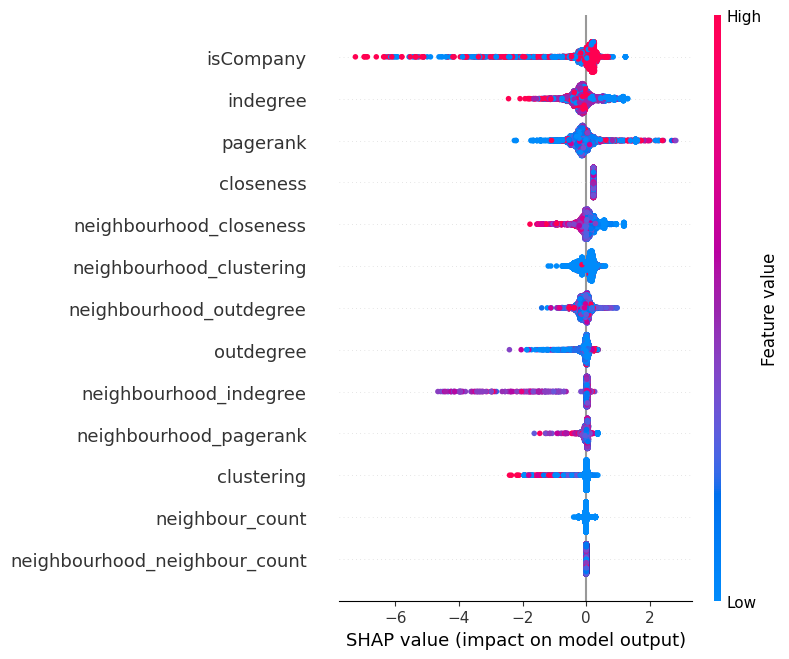

In [16]:
shap.summary_plot(shap_values, X_test)

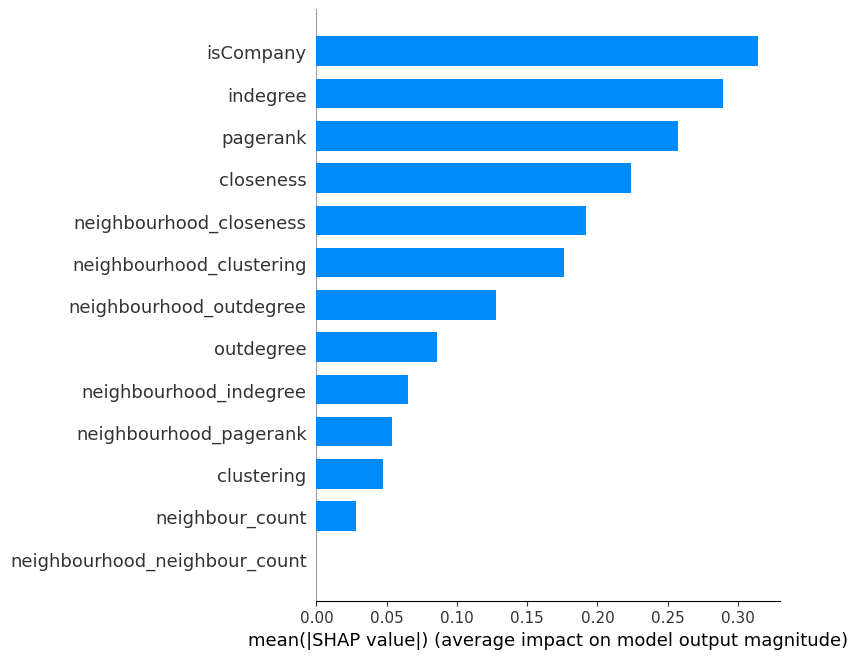

In [17]:
# Plot partial dependence plots.
shap.summary_plot(shap_values, X_test, plot_type="bar")

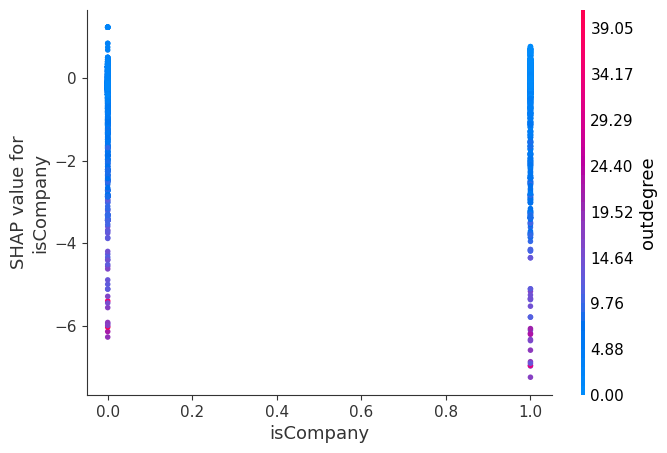

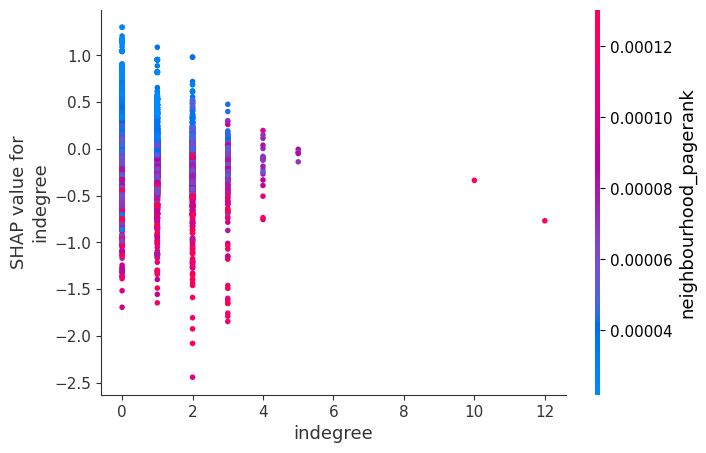

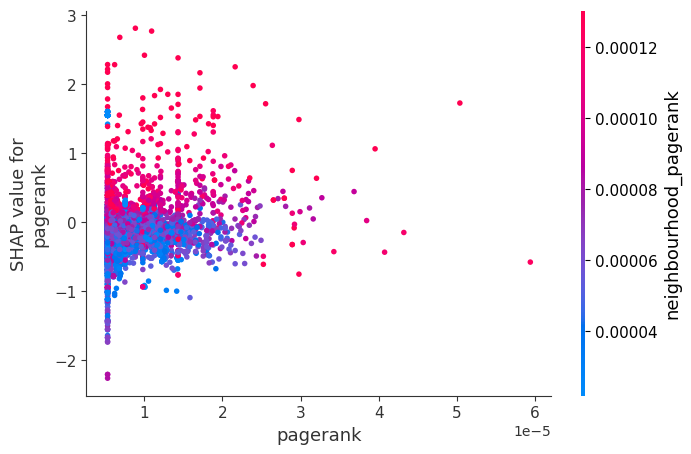

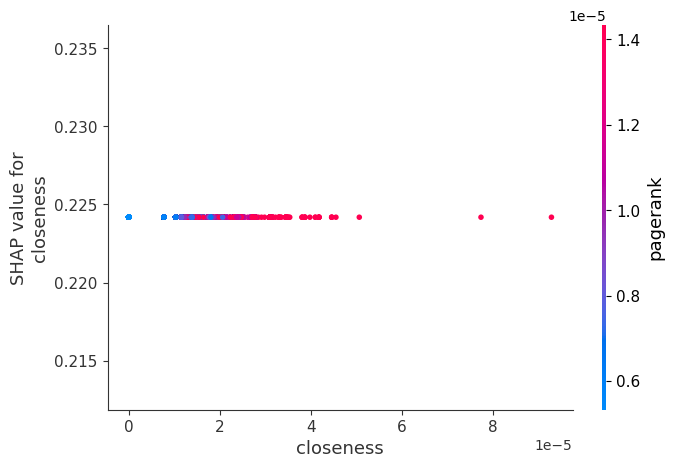

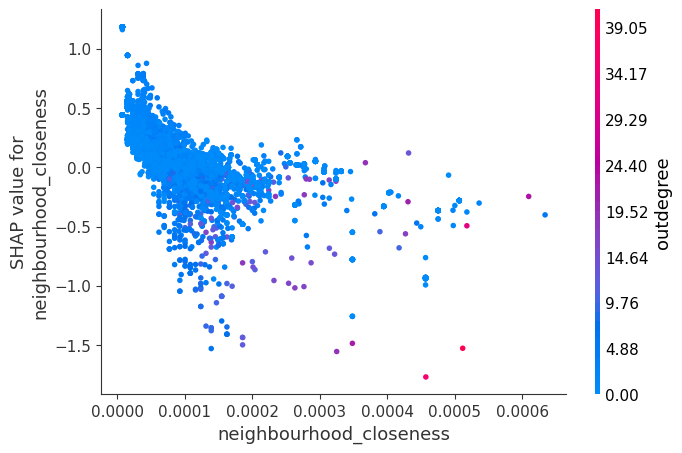

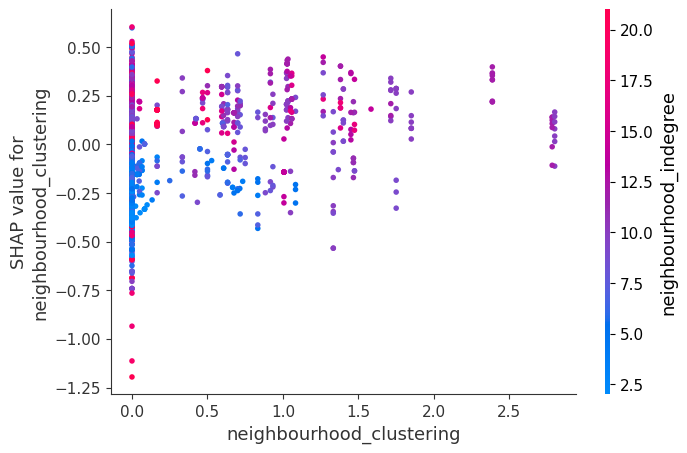

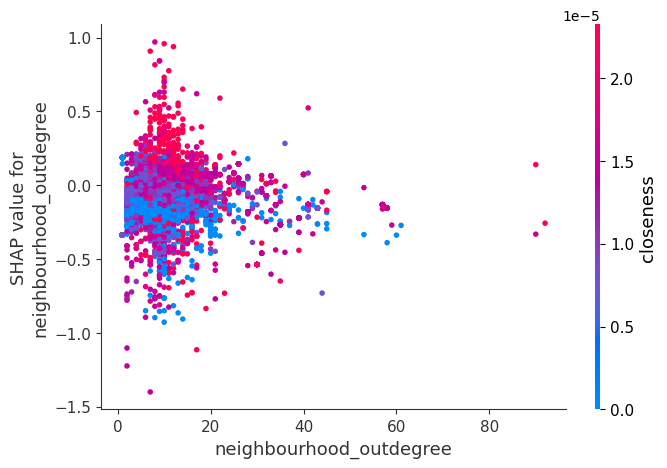

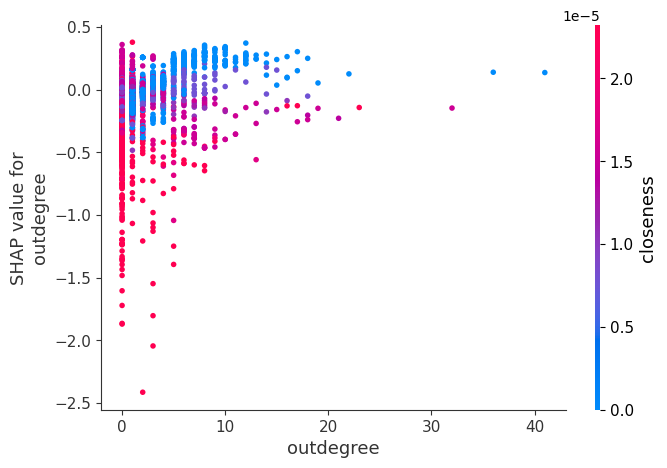

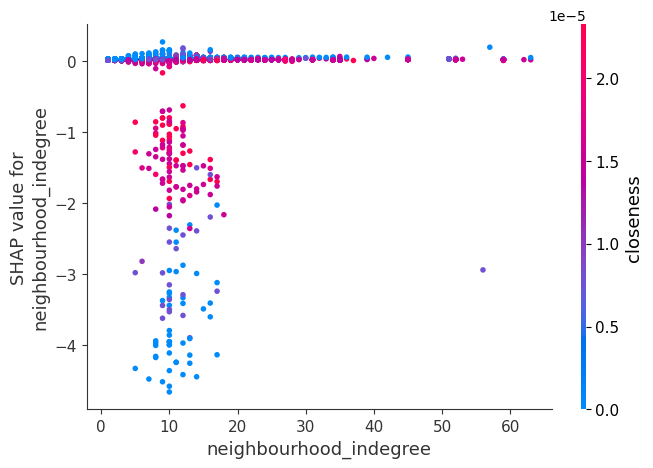

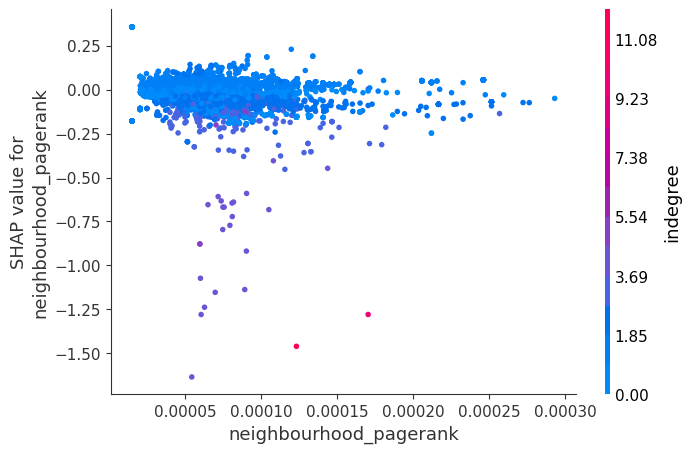

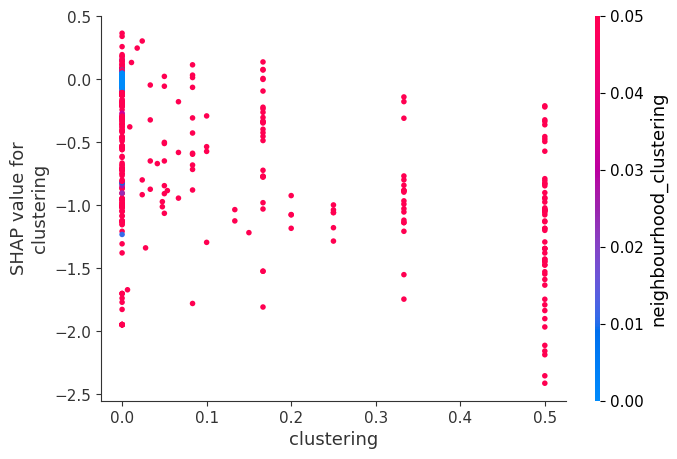

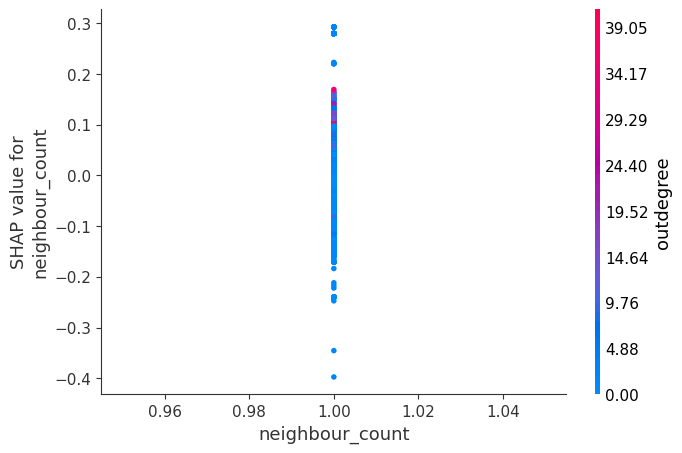

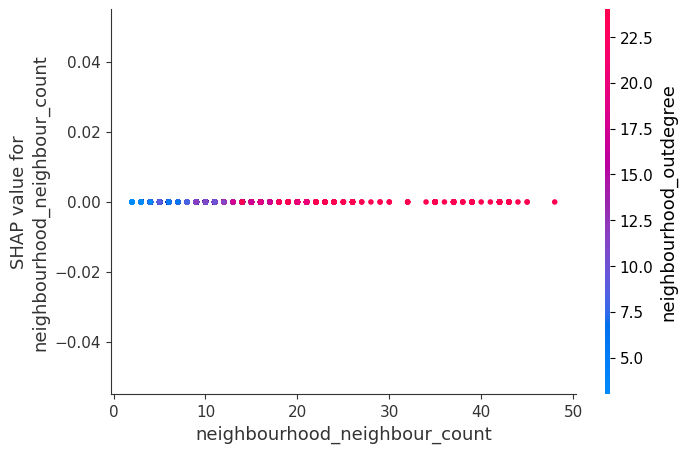

In [18]:
for i in range(X_test.shape[1]):
    shap.dependence_plot(f"rank({i})", shap_values, X_test)
    plt.show()